<a href="https://colab.research.google.com/github/rpandya5/gaitanalysis/blob/main/testing/Quantitative_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading the Libraries and Mounting Drive**


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim
import torch.utils.data
import random
from sklearn import metrics
import matplotlib.pyplot as plt

**Model Architecture**

In [ ]:
class NoNormModel(nn.Module):
  def __init__(self, input_size):
    super(NoNormModel, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 3, relu, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 128 filters, kernel size 3, relu, maxpooling size 2
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 256 filters, kernel size 3, relu, maxpooling size 2
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=256, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out

In [ ]:
#Loading the trained model
model_6 = torch.load('/content/gdrive/MyDrive/Copy of model_6.pth')

In [ ]:
model_6.eval()

NoNormModel(
  (cnn_layers): Sequential(
    (0): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm_1): LSTM(256, 100, batch_first=True)
  (lstm_2): LSTM(100, 100, batch_first=True)
  (fully_connected): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)

**Quantitative Analysis**

The team has chosen the following quantitative measures for evaluating our best model:

1. Accuracy: Accuracy gives a measure of the overall correctness of the model, i.e. percentage of the model's outputs that the model classified correctly. This metric is necessary as the team aims to identify all activities correctly via the model.

2. Sensitivity: Sensitivity gives a measure of the percentage of Positive samples that were classified correctly. As the problem of Fall Detection is extremely sensitive and that false negatives (Falls marked as ADLs) can lead to loss of human life, the team believes that Sensitivity will help us measure how accurately can our model can predict Falls. A high sensitivity will ensure that our model is truly serving it's purpose of detecting Falls and is able to maximise its impact in real life.

3. Specificity: Specificity gives a measure of the percentage of Negative Samples that were classified correctly. A high specificity ensures that the model is correctly able to identify ADLs. Since False classification of ADLs as Falls will disrupt user experience, it is important that our model is able to detect ADLs with high accuracy.


**Quantitative Results on SisFall (Training Datatset)**

Accuracy = 99.20488165680473%

Sensitivity = 98.33147942157954%

Specificity = 99.6398891966759%

In [ ]:
#Helper Functions
def plot_train_val(epoch_list, train_loss, val_loss, title):
    # Plotting

  fig, ax = plt.subplots(figsize=(6, 5))

  plt.title(title+" Curve")

  colors = ["#8D99AE", "#EF233C"]
  # Plot the baseline text
  plt.text(
    epoch_list[-1] * 1.01,
    train_loss[-1],
    "Training " + title,
    color=colors[0],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  plt.text(
    epoch_list[-1] * 1.01,
    val_loss[-1],
    "Validation " + title,
    color=colors[1],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  # Hide the all but the bottom spines (axis lines)
  ax.spines["right"].set_visible(False)
  #ax.spines["left"].set_visible(False)
  ax.spines["top"].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position("left")
  ax.xaxis.set_ticks_position("bottom")
  #ax.spines["bottom"].set_bounds(min(x), max(x))


  plt.plot(epoch_list, train_loss, label="Train", color = colors[0], linewidth = 2)
  plt.plot(epoch_list, val_loss, label="Validation", color = colors[1], linewidth = 2)
  plt.xlabel("Epoch")
  plt.ylabel(title)
  plt.legend(loc='best')
  plt.show()

def get_labels(data):
  #Returns the labels
  list = []
  for elem in data:
    list.append(int(elem[-1]))
  return list

def listOfTuples(l1, l2):
  #Merging
  return list(map(lambda x, y:(x,y), l1, l2))

def get_acc(model, data, batch_size):
  #Modified to incorporate for evaluation metrics
  correct = 0
  total = 0
  error = 0
  out_list = torch.tensor([])
  for img, labels in torch.utils.data.DataLoader(data, batch_size = batch_size):
    output = model(img)
    output = torch.sigmoid(output) # Gets the decimal estimations of fall / no fall
    estimate = torch.round(output) # Rounds each estimate to 1 or 0 --> fall or no fall
    diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
    temp = torch.sum(diff) # Sums all the error estimates
    error = temp.item() + error

    out_list = torch.cat((out_list, output))

  label_list = get_labels(data)
  out_list = out_list.view(-1).cpu().detach().numpy()
  out_list = [round(i) for i in out_list]
  confusion_matrix_2 = metrics.confusion_matrix(label_list, out_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

  cm_display.plot()
  plt.show()

  label_list = np.array(label_list)
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  for i in range(len(label_list)):
    pred = out_list[i]
    label = label_list[i]
    if label == 1 and pred == label:
      tp += 1
    elif label == 1 and pred != label:
      fn += 1
    elif label == 0 and pred == label:
      tn += 1
    else:
      fp += 1

  accuracy = (tp+tn)/(tp+tn+fp+fn)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)

  print('Accuracy=', accuracy)
  print('Sensitivity=', sensitivity)
  print('Specificity=', specificity)

In [ ]:
sis_data = np.load('/content/gdrive/MyDrive/CNN-LSTM Data.npy')
sis_labels = np.load('/content/gdrive/MyDrive/CNN-LSTM Labels.npy')
siscombined = (listOfTuples((torch.from_numpy(sis_data)).to(torch.float), torch.from_numpy(sis_labels).to(torch.float)))
random.shuffle(combined)

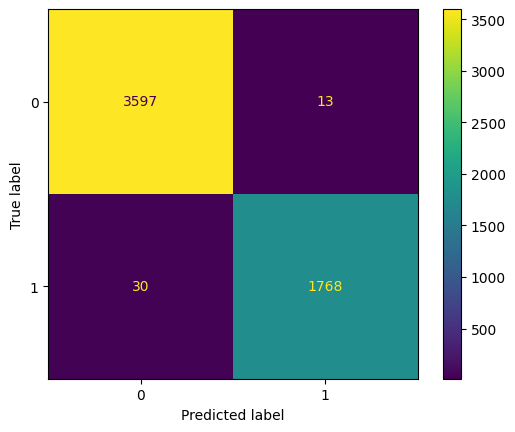

Accuracy= 0.9920488165680473
Sensitivity= 0.9833147942157954
Specificity= 0.996398891966759


In [ ]:
get_acc(model_6, siscombined, 64)

**Quantitative Results on Nick's Phone Collected Data**


In [ ]:
class DataProcessing:
  def __init__(self, window_size = 400, window_overlap = 200):

    #Features we extract from the windows
    self.features = ['X_Acc_Mean', 'X_Acc_Max', 'X_Acc_Std', 'X_Acc_Min',
                     'X_Acc_IQR', 'X_Acc_Skew', 'X_Acc_Kurtosis', 'X_Acc_Energy', 'X_Acc_Jerk',
                     'Y_Acc_Mean', 'Y_Acc_Max', 'Y_Acc_Std', 'Y_Acc_Min',
                     'Y_Acc_IQR', 'Y_Acc_Skew', 'Y_Acc_Kurtosis', 'Y_Acc_Energy', 'Y_Acc_Jerk',
                     'Z_Acc_Mean', 'Z_Acc_Max', 'Z_Acc_Std', 'Z_Acc_Min',
                     'Z_Acc_IQR', 'Z_Acc_Skew', 'Z_Acc_Kurtosis', 'Z_Acc_Energy', 'Z_Acc_Jerk',
                     'XY_Acc_Cov', 'X_Gyro_Mean', 'X_Gyro_Max', 'X_Gyro_Std', 'X_Gyro_Min',
                     'X_Gyro_IQR', 'X_Gyro_Skew', 'X_Gyro_Kurtosis', 'X_Gyro_Energy', 'X_Gyro_Jerk',
                     'Y_Gyro_Mean', 'Y_Gyro_Max', 'Y_Gyro_Std', 'Y_Gyro_Min',
                     'Y_Gyro_IQR', 'Y_Gyro_Skew', 'Y_Gyro_Kurtosis', 'Y_Gyro_Energy', 'Y_Gyro_Jerk',
                     'Z_Acc_Mean', 'Z_Gyro_Max', 'Z_Gyro_Std', 'Z_Gyro_Min',
                     'Z_Gyro_IQR', 'Z_Gyro_Skew', 'Z_Gyro_Kurtosis', 'Z_Gyro_Energy', 'Z_Gyro_Jerk',
                     'XY_Gyro_Cov']

    self.window_size = window_size # window size is 2 seconds
    self.window_overlap = window_overlap # Overlap is 1 second

  #Feature Extraction Done by Anya and Nick
  def getcov(self, x_list_1, x_bar ,y_list, y_bar):
    """ Calculates the covariance of x and y in the selected window.

    Parameters:
    -----------
        x_list_1 : list
        x_bar :
          Average of x list
        y_list : list
        y_bar : float
          Average of y list

    Returns:
    --------
        covariace of x and y : float

    """
    cov = []
    for i in range(len(x_list_1)):
        cov.append((x_list_1[i] - x_bar) * (y_list[i] - y_bar))
    return sum(cov) / len(x_list_1) - 1

  def jerk(self, x_list, t_step):
    """ Calculated jerk, or the rate of change of the acceleration.

    Parameters:
    -----------
    x_list : list
    t_step : float

    Returns:
    --------
    jerk_list : list

    """
    jerk_list = []
    for i in range(len(x_list)-1):
        jerk_list.append((x_list[i+1] - x_list[i]) / t_step)

    jerk_list.append(jerk_list[-1])
    return sum(jerk_list) / len(jerk_list)

  def energy(self, x_list):
    """ Avergaged energy of the corresponding window

    Parameters:
    -----------
    x_list : list

    Returns:
    --------
    energy : float

    """
    sum = 0
    for i in range(len(x_list)):
        sum += x_list[i]**2
    return sum / len(x_list)


  #Nick add your functions here (also add self as the first parameter)
  def butter_lowpass_filter(self, data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

  def getmean(self,df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.mean()

  def getstd(self,df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.std()

  def getmin(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.min()

  def getmax(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.max()

  def getmedian(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.median()

  def getskewness(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.skew()

  def getkurtosis(self, df, col):
    """ if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.kurtosis()

  def getiqr(self, df, col):
    """ if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.quantile(0.75) - x.quantile(0.25)
  #Window Sampling done by Krish
  def window_sample(self, file_df):
    """
    Description: Converts sensor readings of 15 seconds (200 Hz) into windows

    Inputs:   dir- path to the directory where the file is stored
              file- Name of the file with the sensor data

    Outputs:  DataFrame with the windows and features extracted
    """

    #Window size for activities is 2 seconds with a one second overlap
    window_x = 1
    new_df = []
    for i in range(0, len(file_df)-self.window_overlap, self.window_overlap):
      window = file_df.iloc[i:i+self.window_size:]
      sampled = []

      #Calling all functions for the specific window
      sampled.append(self.getmean(window, 'X_Acc_1'))
      sampled.append(self.getmax(window, 'X_Acc_1'))
      sampled.append(self.getstd(window, 'X_Acc_1'))
      sampled.append(self.getmin(window, 'X_Acc_1'))
      sampled.append(self.getiqr(window, 'X_Acc_1'))
      sampled.append(self.getskewness(window, 'X_Acc_1'))
      sampled.append(self.getkurtosis(window, 'X_Acc_1'))
      sampled.append(self.energy(window['X_Acc_1'].tolist()))
      sampled.append(self.jerk(window['X_Acc_1'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Y_Acc_1'))
      sampled.append(self.getmax(window, 'Y_Acc_1'))
      sampled.append(self.getstd(window, 'Y_Acc_1'))
      sampled.append(self.getmin(window, 'Y_Acc_1'))
      sampled.append(self.getiqr(window, 'Y_Acc_1'))
      sampled.append(self.getskewness(window, 'Y_Acc_1'))
      sampled.append(self.getkurtosis(window, 'Y_Acc_1'))
      sampled.append(self.energy(window['Y_Acc_1'].tolist()))
      sampled.append(self.jerk(window['Y_Acc_1'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Z_Acc_1'))
      sampled.append(self.getmax(window, 'Z_Acc_1'))
      sampled.append(self.getstd(window, 'Z_Acc_1'))
      sampled.append(self.getmin(window, 'Z_Acc_1'))
      sampled.append(self.getiqr(window, 'Z_Acc_1'))
      sampled.append(self.getskewness(window, 'Z_Acc_1'))
      sampled.append(self.getkurtosis(window, 'Z_Acc_1'))
      sampled.append(self.energy(window['Z_Acc_1'].tolist()))
      sampled.append(self.jerk(window['Z_Acc_1'].tolist(), (2/self.window_size)))
      sampled.append(self.getcov(window['X_Acc_1'].tolist(), self.getmean(window, 'X_Acc_1'), window['Y_Acc_1'].tolist(), self.getmean(window, 'Y_Acc_1')))


      sampled.append(self.getmean(window, 'X_Gyro'))
      sampled.append(self.getmax(window, 'X_Gyro'))
      sampled.append(self.getstd(window, 'X_Gyro'))
      sampled.append(self.getmin(window, 'X_Gyro'))
      sampled.append(self.getiqr(window, 'X_Gyro'))
      sampled.append(self.getskewness(window, 'X_Gyro'))
      sampled.append(self.getkurtosis(window, 'X_Gyro'))
      sampled.append(self.energy(window['X_Gyro'].tolist()))
      sampled.append(self.jerk(window['X_Gyro'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Y_Gyro'))
      sampled.append(self.getmax(window, 'Y_Gyro'))
      sampled.append(self.getstd(window, 'Y_Gyro'))
      sampled.append(self.getmin(window, 'Y_Gyro'))
      sampled.append(self.getiqr(window, 'Y_Gyro'))
      sampled.append(self.getskewness(window, 'Y_Gyro'))
      sampled.append(self.getkurtosis(window, 'Y_Gyro'))
      sampled.append(self.energy(window['Y_Gyro'].tolist()))
      sampled.append(self.jerk(window['Y_Gyro'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Z_Gyro'))
      sampled.append(self.getmax(window, 'Z_Gyro'))
      sampled.append(self.getstd(window, 'Z_Gyro'))
      sampled.append(self.getmin(window, 'Z_Gyro'))
      sampled.append(self.getiqr(window, 'Z_Gyro'))
      sampled.append(self.getskewness(window, 'Z_Gyro'))
      sampled.append(self.getkurtosis(window, 'Z_Gyro'))
      sampled.append(self.energy(window['Z_Gyro'].tolist()))
      sampled.append(self.jerk(window['Z_Gyro'].tolist(), (2/self.window_size)))
      sampled.append(self.getcov(window['X_Gyro'].tolist(), self.getmean(window, 'X_Gyro'), window['Y_Gyro'].tolist(), self.getmean(window, 'Y_Gyro')))

      new_df.append(sampled)
      window_x += 1

    #Returns the created DataFrame
    return pd.DataFrame(new_df, columns=self.features)

In [ ]:
def get_data(activity, folder = '/content/gdrive/MyDrive/Processed Data'):
  data = []
  for dir, _, files in os.walk(folder):
    for file in files:
      file_df = pd.read_csv(os.path.join(dir, file))
      file_df = file_df.drop(['Unnamed: 0', 'Window'], axis=1)
      if file[:3] == activity:
        data.append(np.array(file_df))
  data = np.array(data)
  if activity == 'F':
    k = 1
  else:
    k = 0
  labels = np.array([k for i in range(len(data))])
  combined = listOfTuples((torch.from_numpy(data)).to(torch.float), torch.from_numpy(labels).to(torch.float))
  random.shuffle(combined)
  return combined

In [ ]:
phone_data = []
phone_labels = []
sampler = DataProcessing(20, 10)
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data'):
  for file in files:
    if file[0] == 'p':
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      file_df = file_df[20:170]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(1)
    else:
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      if len(file_df)<150:
        cols = file_df.columns
        file_np = np.array(file_df)
        file_df = pd.DataFrame(np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_df), 1))))), columns=cols)
      elif len(file_df)>150:
        file_df = file_df[:150]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(0)

In [ ]:
phone_data = np.array(phone_data)
phone_labels = np.array(phone_labels)
phonecombined = (listOfTuples((torch.from_numpy(phone_data)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

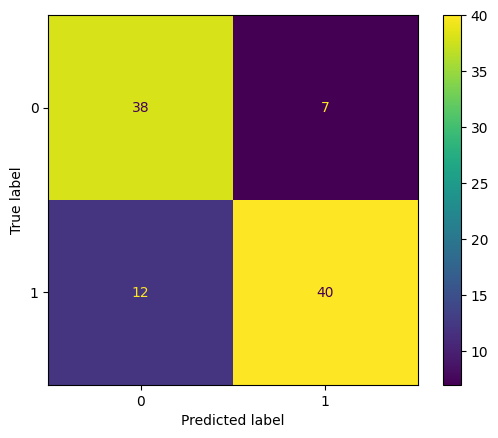

Accuracy= 0.8041237113402062
Sensitivity= 0.7692307692307693
Specificity= 0.8444444444444444


In [ ]:
get_acc(model_6, phonecombined, 64)